# DS-SF-25 | Codealong and Lab 15 | Time Series | Answer Key

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sb

# Codealong - Exploring Rossmann Drug Store Sales Data

## Part A - Data Exploration

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'rossmann.csv'),
                 skipinitialspace = True,
                 low_memory = False)

In [3]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [5]:
df.Date

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, dtype: object

In [6]:
df.Date = pd.to_datetime(df.Date)

In [7]:
df.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, dtype: datetime64[ns]

In [8]:
df.set_index('Date', inplace = True)

df['Year'] = df.index.year
df['Month'] = df.index.month

Let's focus on the first store.

In [9]:
df = df[df.Store == 1]

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

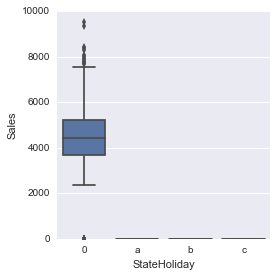

In [10]:
sb.factorplot(x = 'StateHoliday',
              y = 'Sales',
              data = df,
              kind = 'box')

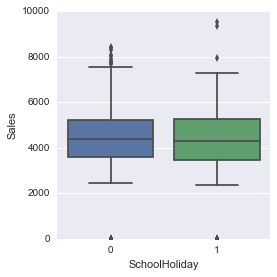

In [11]:
sb.factorplot(x = 'SchoolHoliday',
              y = 'Sales',
              data = df,
              kind = 'box')

> Check: See if there is a difference affecting sales on promotion days.

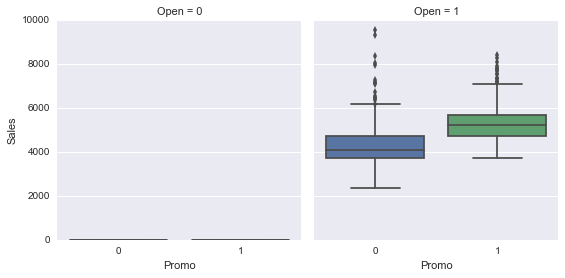

In [12]:
sb.factorplot(col = 'Open',
              x = 'Promo',
              y = 'Sales',
              data = df,
              kind = 'box')

## Part B - Seasonality, Trends, and Cycles

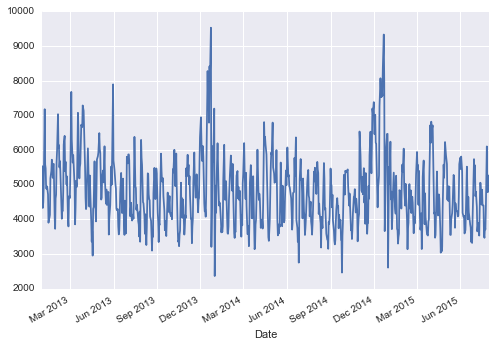

In [13]:
df[df.Open == 1].Sales.plot()

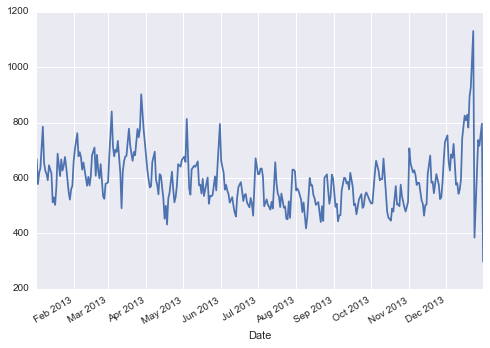

In [14]:
df[(df.Open == 1) & (df.Year == 2013)].Customers.plot()

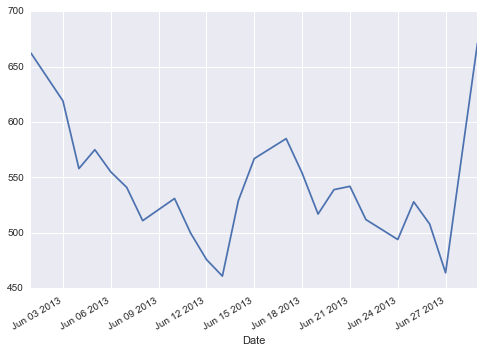

In [15]:
df[(df.Open == 1) & (df.Year == 2013) & (df.Month == 6)].Customers.plot()

## Part C - Rolling Averages; `pandas` Window and Expending Functions

In `pandas`, we can compute rolling averages using the `Series.rolling` function.

### Rolling averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In `pandas`, this is performed using the `resample` command, which is very similar to the `groupby` command.  It allows us to group over different time intervals.

We can use `Series.resample` and provide as arguments:
- The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
- What aggregation to perform: '.mean()', '.median()', 'sum.()', etc.

In [16]:
df.Sales.resample(rule = 'M').mean()

Date
2013-01-31    4142.935484
2013-02-28    4473.964286
2013-03-31    4682.870968
2013-04-30    3933.633333
2013-05-31    3813.709677
                 ...     
2015-03-31    3836.032258
2015-04-30    3688.500000
2015-05-31    3394.193548
2015-06-30    3667.033333
2015-07-31    3911.806452
Freq: M, Name: Sales, dtype: float64

In [17]:
df.Sales.resample(rule = 'M').median()

Date
2013-01-31    4717.0
2013-02-28    5118.5
2013-03-31    5506.0
2013-04-30    4378.0
2013-05-31    4624.0
               ...  
2015-03-31    4005.0
2015-04-30    4139.5
2015-05-31    4211.0
2015-06-30    4045.0
2015-07-31    4395.0
Freq: M, Name: Sales, dtype: float64

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window.  To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it.  We can do this using rolling averages.

In `pandas`, we can compute rolling averages using the `Series.rolling` function.

In [18]:
df.Sales.resample(rule = 'D').mean().\
    rolling(window = 3, center = True).mean()

Date
2013-01-01            NaN
2013-01-02    3285.666667
2013-01-03    4781.000000
2013-01-04    4603.333333
2013-01-05    3161.000000
                 ...     
2015-07-27    3704.333333
2015-07-28    5298.333333
2015-07-29    4937.666667
2015-07-30    5021.666667
2015-07-31            NaN
Freq: D, Name: Sales, dtype: float64

`rolling` takes these important parameters:
- `window` is the number of days to include in the average
- `center` is whether the window should be centered on the date or use data prior to that date

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

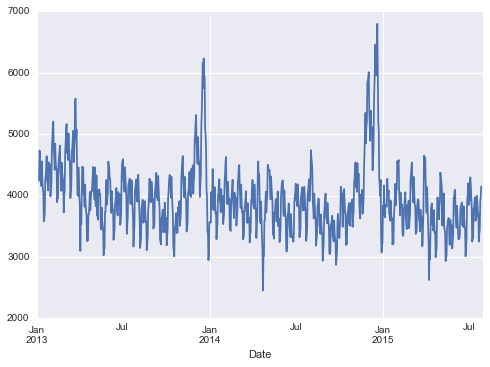

In [19]:
df.Sales.resample(rule = 'D').mean().\
    rolling(window = 10, center = True).mean().\
    plot()

### `pandas` window functions

`pandas`' `rolling` is only one examples of `pandas`' window function capabilities.  Window functions are operate on a set of N consecutive rows (a window) and produce an output.

Another common one is `diff`, which takes the difference over time.  `Series.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.

In [20]:
df.Sales.diff(periods = 1)

Date
2015-07-31       NaN
2015-07-30    -243.0
2015-07-29    -238.0
2015-07-28     229.0
2015-07-27    1091.0
               ...  
2013-01-05    4997.0
2013-01-04    -511.0
2013-01-03    -159.0
2013-01-02    1203.0
2013-01-01   -5530.0
Name: Sales, dtype: float64

### `pandas` expanding functions

In addition to the `rolling` function, `pandas` also provides a similar `expanding` function, which, instead of using a window of N values, use all values up until that time.

In [21]:
# computes the average sales, from the first date _until_ the date specified.

df.Sales.resample(rule = 'd').mean().\
    expanding().mean()

Date
2013-01-01       0.000000
2013-01-02    2765.000000
2013-01-03    3285.666667
2013-01-04    3585.750000
2013-01-05    3868.000000
                 ...     
2015-07-27    3941.127932
2015-07-28    3942.267306
2015-07-29    3943.160638
2015-07-30    3944.304995
2015-07-31    3945.704883
Freq: D, Name: Sales, dtype: float64

## Part D - Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column.  In `pandas`, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation.  If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it.  Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [22]:
df.Sales.resample(rule = 'D').mean().autocorr(lag = 1)

-0.12732514339140213

## Lab

> ### Question 1.  Plot the distribution of sales by month and compare the effect of promotions

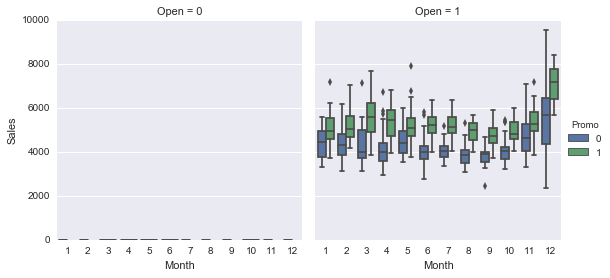

In [23]:
sb.factorplot(col = 'Open',
             hue = 'Promo',
             x = 'Month',
             y = 'Sales',
             data = df,
             kind = 'box')

> ### Question 2.  Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [24]:
average_daily_sales_df = df[ ['Sales', 'Open'] ].resample(rule = 'D').mean()

print('Correlation with last day:   {}'.format(average_daily_sales_df.Sales.autocorr(lag = 1)))
print('Correlation with last month: {}'.format(average_daily_sales_df.Sales.autocorr(lag = 30)))
print('Correlation with last year:  {}'.format(average_daily_sales_df.Sales.autocorr(lag = 365)))

Correlation with last day:   -0.127325143391
Correlation with last month: -0.0794070299952
Correlation with last year:  -0.0581932157053


> ### Question 3.  Plot the 15 day rolling mean of customers in the stores

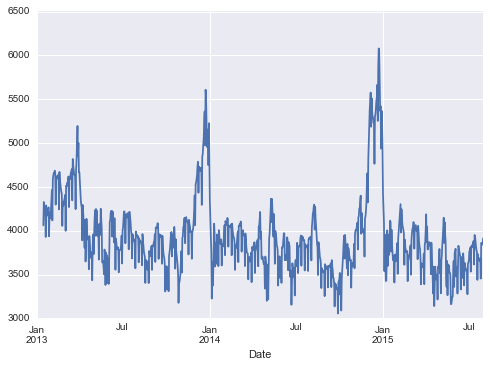

In [25]:
df.Sales.resample(rule = 'D').mean().\
    rolling(window = 15).mean().\
    plot()

> ### Question 4.  Identify the dates with largest drop in sales from the same date in the previous month

In [26]:
average_daily_sales_df = df[ ['Sales', 'Open'] ].resample(rule = 'D').mean()
average_daily_sales_df['DiffVsLastWeek'] = average_daily_sales_df.Sales.diff(periods = 7)

average_daily_sales_df.sort_values(by = 'DiffVsLastWeek')

,Sales,Open,DiffVsLastWeek
Date,,,
2013-12-25,0,0,-7821.0
2014-12-25,0,0,-7785.0
2014-12-26,0,0,-7558.0
2014-04-21,0,0,-6803.0
2013-12-26,0,0,-6788.0
...,...,...,...
2013-01-03,4327,1,NaN
2013-01-04,4486,1,NaN
2013-01-05,4997,1,NaN


Unsurprisingly, the top values are December 25 and 26 in 2014 and 2015 (when the store is closed and there are many sales in the preceding week).  How, about when the store is open?

In [27]:
average_daily_sales_df[average_daily_sales_df.Open == 1].sort_values(by = 'DiffVsLastWeek')

,Sales,Open,DiffVsLastWeek
Date,,,
2013-12-24,3204,1,-4152.0
2014-12-24,3659,1,-3864.0
2013-06-07,4315,1,-3578.0
2015-04-09,3467,1,-3107.0
2013-04-04,4293,1,-2992.0
...,...,...,...
2013-01-02,5530,1,NaN
2013-01-03,4327,1,NaN
2013-01-04,4486,1,NaN


The top values are December 24 in 2013 and 2014 where on average sales were 4k lower than the same day in the previous week.

> ### Question 5.  Compute the total sales up until December 2014

In [28]:
df.Sales.resample(rule = 'D').sum().\
    expanding().sum()['2014-12']

# Note that this is **not**
#
# df.Sales.expanding(freq = 'D').sum()
#
# since we do not, want to first average over stores.

Date
2014-12-01    2770902.0
2014-12-02    2777369.0
2014-12-03    2783823.0
2014-12-04    2790839.0
2014-12-05    2797046.0
                ...    
2014-12-27    2909014.0
2014-12-28    2909014.0
2014-12-29    2915477.0
2014-12-30    2921943.0
2014-12-31    2924548.0
Freq: D, Name: Sales, dtype: float64

> ### Question 6.  When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `resample`, `rolling` and `diff`

In [29]:
df.Sales.resample(rule = 'D').mean().\
    rolling(window = 15).mean().\
    diff(1).sort_values()

Date
2015-01-04   -557.800000
2014-01-05   -536.200000
2015-01-01   -501.533333
2014-01-01   -490.400000
2014-12-28   -484.200000
                 ...    
2013-01-11           NaN
2013-01-12           NaN
2013-01-13           NaN
2013-01-14           NaN
2013-01-15           NaN
Name: Sales, dtype: float64

Unsurprisingly, they occur at the beginning or at the end of every year after the holiday season.